<a href="https://colab.research.google.com/github/kyledawson/interviews/blob/main/Environmental_Data_Scientist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environmental Data Scientist Technical Interview


---

This challenge is composed of 3 parts. For the first 2 parts, you are requested to use this notebook. For part 3, you are allowed to download the dataset and work in your own environment and software of choice (e.g., MATLAB) or stay in the Google colab notebook.

# Part 1 - Fun with SQL
## Preamble
An SQLite database is provided to you. The structure of the database contains two tables with the following columns:

![ER Diagram](https://drive.google.com/uc?export=view&id=1uNxcESjCJI4Fp-iM2IAgscSPGZOknrZs)

In [ ]:
%load_ext sql
# Load the sql extension

In [ ]:
# Connect to the SQLite Database
from sqlalchemy import create_engine
my_conn=create_engine("sqlite:////content/drive/MyDrive/Colab Notebooks/Data/env_data_sci.db")

In [ ]:
# Define your DB Query
query = """
select *
from api_measurement
limit 10;
"""

In [ ]:
from sqlalchemy import text
import pandas as pd
# Get your results
with my_conn.connect() as conn:
    result = pd.read_sql(text(query),conn)
result.head()

,survey_id,timestamp,longitude,latitude,altitude,concentration
0,16021,2022-02-10 12:16:48.100 -0600,-117.120361,33.914812,0.09,1.773
1,16021,2022-02-10 12:16:48.200 -0600,-117.120361,33.914812,0.09,1.714
2,16021,2022-02-10 12:16:48.300 -0600,-117.120361,33.914812,0.09,1.739
3,16021,2022-02-10 12:16:48.400 -0600,-117.120361,33.914812,0.09,1.760
4,16021,2022-02-10 12:16:48.500 -0600,-117.120361,33.914812,0.09,1.773


# Now it's your turn

1. Can you query a result set for a customer who wants a table of co-located wind speed, concentration, and altitude for survey number `16022`? The answer should look as follows after executing:
```python
> result.head()
```

index | survey_id	| timestamp |	longitude |	latitude |	altitude	| concentration	|wind_u	| wind_v	| wind_w
-----|-----|-----|-----|-----|-----|-----|-----|----- | -----
0 |	16022 |	2022-02-10 12:45:22.700 -0600 |	-117.12103 |	33.914672 |	0.01 |	1.513 |	2.749105 |	-1.201009 |	0.0 |
1	| 16022	| 2022-02-10 12:45:22.800 -0600	| -117.12103 |	33.914672	| 0.01	| 1.525	| 2.749105	| -1.201009	| 0.0 |
2 |	16022	| 2022-02-10 12:45:22.900 -0600 |	-117.12103 |	33.914672	| 0.01	| 1.532	| 2.749105	| -1.201009	| 0.0 |
3 |	16022	| 2022-02-10 12:45:23.000 -0600	| -117.12103 |	33.914672	| 0.01 |	1.508	| 2.749105	| -1.201009	| 0.0 |
4	| 16022 |	2022-02-10 12:45:23.100 -0600	| -117.12103	| 33.914672 |	0.01	| 1.523	| 2.749105	| -1.201009	| 0.0 |


In [ ]:
# Write your query here:
query = """
with meas as (
    select
           am.*
    from api_measurement am
    where (am.survey_id=16022)
    )
 select
   meas.*,
   ab.wind_u,
   ab.wind_v,
   ab.wind_w
 from api_basestationmeasurement ab
 join meas
   on meas.survey_id=ab.survey_id
 where ab.timestamp=meas.timestamp
"""
with my_conn.connect() as conn:
    result = pd.read_sql(text(query),conn)
result.head()


,survey_id,timestamp,longitude,latitude,altitude,concentration,wind_u,wind_v,wind_w
0,16022,2022-02-10 12:45:22.700 -0600,-117.12103,33.914672,0.01,1.513,2.749105,-1.201009,0.0
1,16022,2022-02-10 12:45:22.800 -0600,-117.12103,33.914672,0.01,1.525,2.749105,-1.201009,0.0
2,16022,2022-02-10 12:45:22.900 -0600,-117.12103,33.914672,0.01,1.532,2.749105,-1.201009,0.0
3,16022,2022-02-10 12:45:23.000 -0600,-117.12103,33.914672,0.01,1.508,2.749105,-1.201009,0.0
4,16022,2022-02-10 12:45:23.100 -0600,-117.12103,33.914672,0.01,1.523,2.749105,-1.201009,0.0


# Part 2 - Feature Engineering

Now that your data are in a dataframe format, you can build new features for your specific use case. Using the following information, can you:
1. Please extract the horizontal wind speed magnitude and polar wind direction?
2. Create a new, downsampled to 30 second interval dataframe `result_downsample`.
3. Plot the wind speed magnitude and direction

Horizontal Wind Speed Magnitude | Meteorological Wind Direction (0 - 360 degrees)
--------------------------------|---------------------------------------------
$V = \sqrt{u^2+v^2}$ | $\theta = 270-\tt{atan2}(\frac{v}{u})\times\frac{180}{\pi}$

*Notes:*
* $u$ is positive from the West and $v$ is positive from the South
* Before step 3, set the dataframe to a timestamp index like this:
```python
> time_format = '%Y-%m-%d %H:%M:%S.%f %z'
> result['timestamp'] = pd.to_datetime(result['timestamp'],format=time_format)
> result.set_index('timestamp',inplace=True)
```



In [ ]:
import numpy as np
def wind_dir(u,v):
  dir = 270-np.arctan2(v,u)*180/np.pi
  if dir < 0:
    dir = dir+360
  return dir

result["wind_speed_mag"] = result.apply(lambda x: (x.wind_u**2+x.wind_v**2)**0.5,axis=1)
result["wind_direction"] = result.apply(lambda x: wind_dir(x.wind_u,x.wind_v),axis=1)

In [ ]:
time_format = '%Y-%m-%d %H:%M:%S.%f %z'
result['timestamp'] = pd.to_datetime(result['timestamp'],format=time_format)
result.set_index('timestamp',inplace=True)

In [ ]:
result_downsample = result.resample('30S').mean()

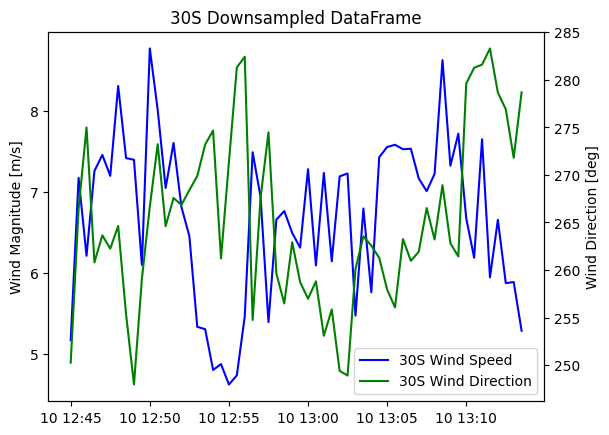

In [ ]:
# Plot the result of the downsampled dataframe:
import matplotlib.pyplot as plt
f = plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
p1, = ax.plot(result_downsample["wind_speed_mag"],c='blue')
p2, = ax2.plot(result_downsample["wind_direction"],c='green')
ax.set_ylabel("Wind Magnitude [m/s]")
ax2.set_ylabel("Wind Direction [deg]")
plt.legend([p1,p2],["30S Wind Speed","30S Wind Direction"])
plt.title("30S Downsampled DataFrame")
plt.show()

# Part 3 - Dataset Exploration

We have a client who would like us to survey their gas flares for methane leaks. The accuracy of these surveys is very important to the client and they would like to understand what factors are most influential on survey accuracy.

How would you analyze the provided dataset to help provide guidance to our client?

We have provided a dataset in `json` format that contains modeled data inputs and outputs for 500 simulations. You are free to work with the dataset within Colab or you can download it and use your preferred analysis software. Please talk through your thought process and ask as many questions as you would like. You are also free to use any other tools at your disposal such as [Stack Overflow](https://www.stackoverflow.com).

We just want to understand your thought process and what ideas/tools you would use to get at this question. A code snippet is provided below for you to quickly import data here within Colab to get cracking.

Have Fun!


In [ ]:
model_data_fname = "/content/drive/MyDrive/Colab Notebooks/Data/modeled_plume_data.json"
model_df = pd.read_json(model_data_fname,orient='index')